*Authors: Pouria Rouzrokh, MD, MPH, MHPE; Elham Mahmoudi, MD, MPH*

# **Semantic Segmentation: A 2D Medical Image Segmentation with PyTorch and MONAI**


#**Image segmentation**

Segmentation is the process of assigning a label to every pixel in an image. Binary segmentation means assigning a '1' or '0' depending on whether it is located inside or outside of an object of interest. Multi-object segmentation might mean assigning '1' to liver, '2' to spleen, (and the list of organs may go on) and '0' to everything else.

There are three main categories of segmentation:

**1. Object Detection** is the process of identifying the objects in an image and localizing them by putting simple bounding boxes around them without finely defining the object's exact borders.  

**2. Image Segmentation** not only localizes the object but also detects the exact borders of the object at pixel-level and represents it as a mask, separating the object from the rest of the image.

**3. Image Classification** is to define or classify each object (e.g., dog, cat, etc.) and confirm it's presence in the image without localizing it.


<img src="https://i.ibb.co/XY396Yc/1.jpg" alt="1" border="0" height="250">


**Semantic segmentation** divides the image into different regions with predefined labels (e.g., cat, dog, human, etc.). It cannot enumerate multiple objects classified with a same label--that means it expects exactly 1 thing.
**Instance segmentation** assigns labels to specific pixels and it also assigns a separate label to each individual object inside a category (e.g., cat1, cat2, cat3, etc.), so that it can count the number of objects in each category.


With this introduction, we are going to train a 2D U-Net model to segment the lungs in the chest X-ray images. The model will take a chest X-ray image as input and outputs a binary mask of the same size, where each pixel is labeled as 0 (background) or 1 (lung). Our method is categorized as semantic segmentation since we do not aim to numerate objects and this method is simpler to implement.

*image source: https://levity.ai/blog/what-is-an-image-classifier*


### **Setting up your programming environment**

The Colaboratory environment was described in previous chapters. Let's have a quick review before we proceed:

#### GPU

Remember to change your runtime type to "GPU" from the top menu:

"Runtime" > "change runtime type" > your "Hardware accelerator" should be GPU if available.

#### Dataset

The dataset we use will be the Darwin chest X-ray dataset, which contains ~6000 chest X-ray images and their corresponding binary segmentation masks.
You can download the Darwin dataset from the following link and upload it to your colab directory:
https://data.mendeley.com/datasets/8gf9vpkhgy

#### Prerequisites

We assume that you have basic knowledge of Python and PyTorch programming, as well as training simple deep learning models with PyTorch. You can find useful material [here](https://pytorch.org/tutorials/).

#### Code setup
For the purpose of education, our coding approach is a bit different from a real-world segmentation project in these aspects:

1- We are going to put a whole segmentation project's code in a single notebook, which is not the preferred approach in real projects.
Usually, the code for data loading,  model definition, model training, model evaluation and other functions are stored in distinct files (Python 'modules').

2- Compared to a real project, we will use a smaller batch size and a smaller number of epochs for training the model. We do so to simplify the learning process and keep training times reasonable but this method is not optimized for performance.

3- To make everything simple and clear, we put the majority of the code in the  cells in this notebook. In a real project you will use more functions and classes.

### **Setup**
Let's start by installing the MONAI package, and then import the required packages.
We will also download the data for this notebook from Google Drive.

In [1]:
!pip install -q monai==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00


In [2]:

# Standard library modules
import glob
import os
import random
import shutil
import zipfile

# Third-party library modules
import matplotlib.pyplot as plt
import monai as mn
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm
import torch
import torchsummary
import warnings

warnings.filterwarnings("ignore")

In [3]:
# !unzip -q "2D_segmentation_data.zip"

In [3]:
# Download and organize project data

import gdown
gdown.download(
        "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1jlWo_2uPsYX9Ir1E0ogw4znwNJvau_y3",
        "2D_segmentation_data.zip",
        quiet=False,
    )
!unzip -q "2D_segmentation_data"
shutil.rmtree('sample_data', ignore_errors=True)
os.rename('2D_segmentation_data', 'data')
shutil.move('data/weights', 'weights')
os.remove('2D_segmentation_data.zip')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1jlWo_2uPsYX9Ir1E0ogw4znwNJvau_y3
To: /content/2D_segmentation_data.zip
100%|██████████| 1.87G/1.87G [00:21<00:00, 88.7MB/s]


### **Data Collection**

The data for training a segmentation model should contain a set of images and their corresponding segmentation masks. The segmentation masks are usually annotated manually by experts and stored as binary images. Each pixel in a binary mask image is labeled as 0 (background) or 1 (the area of interest). If there is more than 1 class of objects, each pixel can be labeled as 0, 1, 2, etc. (0=background, 1=dog, 2=cat, etc).

We have previously discussed data preprocessing in detail in chapters 6 and 7. With this background we will go through some necessary steps to handle our datasets, in the following cells.


In [5]:
# Creating a list of paths for all images and their corresponding masks

root_dir = 'data/Darwin'
image_dir = os.path.join(root_dir, 'img')
mask_dir = os.path.join(root_dir, 'mask')
image_paths = glob.glob(os.path.join(image_dir, '*.png'))
mask_paths = glob.glob(os.path.join(mask_dir, '*.png'))

# Let's make sure that each image is linked to its own mask:

assert len(image_paths) == len(mask_paths), 'Number of images and masks do not match!'

print(f'Number of images: {len(image_paths)}')
print(f'Number of masks: {len(mask_paths)}')
print(f'One sample image name: {image_paths[0]}')
print(f'One sample mask name: {mask_paths[0]}')

Number of images: 6106
Number of masks: 6106
One sample image name: data/Darwin/img/00002470_person553_bacteria_2317.png
One sample mask name: data/Darwin/mask/00002470_person553_bacteria_2317.png


In [6]:
# Find out the number of patients and the number of images per patient

patient_names = [path.split('/')[-1].split('_')[1] for path in image_paths]
NUM_PATIENTS = len(set(patient_names))
print(f'Number of patients: {NUM_PATIENTS}')

Number of patients: 3646


In [7]:
# Print the names of the first 20 patient to see how they look!
print(patient_names[:20])

['person553', 'IM-0617-0001.png', 'person515', 'person158', 'NORMAL2-IM-0274-0001.png', 'person1057', 'person371', 'person511', 'fx1', 'person928', '296', 'person431', 'person1518', 'NORMAL2-IM-0468-0001.png', 'person443', 'person1638', 'person1289', 'NORMAL2-IM-0589-0001.png', 'NORMAL2-IM-0045-0001.png', 'person1055']


Looking at the above, it seems that the images match their corresponding masks but some images and masks do not have identifiable subject IDs.
To prevent data leakage further down the line, we have to correct these discrepancies. We should try our best to find the source of this issue and resolve it. If none are identified, we will have to exclude these samples from our dataset, which is not an optimal option.

To perform the next steps, we convert our data to a Pandas dataframe, an organized and easy-to-use format, in which every row will be set to present the name of the patient who owns an image, the path to the image, and the path to its corresponding segmentation mask.

In [8]:
# Putting together a dataframe with data for images with "determinate" patient IDs

patient_column = []; image_column = []; mask_column = []
for name, image_path, mask_path in zip(patient_names, image_paths, mask_paths):
    if 'person' in name.lower():
        patient_column.append(name)
        image_column.append(image_path)
        mask_column.append(mask_path)
data_df = pd.DataFrame({'patient': patient_column, 'image': image_column, 'mask': mask_column})
print(f'Number of records after data cleaning: {len(data_df)}')
data_df.head()

Number of records after data cleaning: 3984


,patient,image,mask
0,person553,data/Darwin/img/00002470_person553_bacteria_23...,data/Darwin/mask/00002470_person553_bacteria_2...
1,person515,data/Darwin/img/00000762_person515_virus_1032.png,data/Darwin/mask/00000762_person515_virus_1032...
2,person158,data/Darwin/img/00001051_person158_virus_312.png,data/Darwin/mask/00001051_person158_virus_312.png
3,person1057,data/Darwin/img/00004349_person1057_bacteria_2...,data/Darwin/mask/00004349_person1057_bacteria_...
4,person371,data/Darwin/img/00003073_person371_bacteria_16...,data/Darwin/mask/00003073_person371_bacteria_1...


By excluding the unidentified records from 6106 images, only 3984 images remain in the dataset, a loss of about 1/3 of the data. We must try to reduce this data loss.

### **Exploratory Data Analysis (EDA)**

After data collection, we will perform some exploratory data analysis (EDA) to get a better understanding of our data. This will help us make better decisions when we are designing the training pipeline. The number of data aspects that we can look at is almost infinite. Here, we will look at a few critical ones.

**Step 1- Number of images per patient**: Let's start by plotting the number of images per patient to visualize their distribution. This will guide us in the proper splitting of the data into training and test sets.

Text(0, 0.5, 'Number of patients')

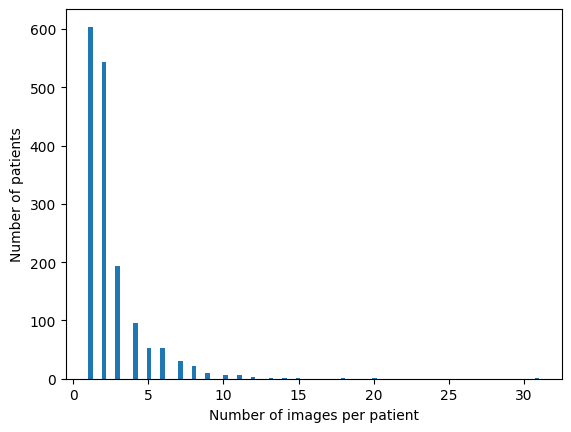

In [9]:
# Plot the distribution of the number of images per patient

unique_patients, counts = np.unique(patient_column, return_counts=True)
plt.hist(counts, bins=100);
plt.xlabel('Number of images per patient')
plt.ylabel('Number of patients')

**Step 2- Matching images and masks**: No EDA is complete without looking at the original images and their corresponding segmentation masks. Doing so will help us understand the ground truth data better and possibly identify issues with the data. For example, we may find that some masks are not aligned with the corresponding image, or some masks don't cover the entire areas of interest.

A deep learning model can only be as good as the data on which it is trained. Therefore, it is always a good idea to look at the data before you start training the model.

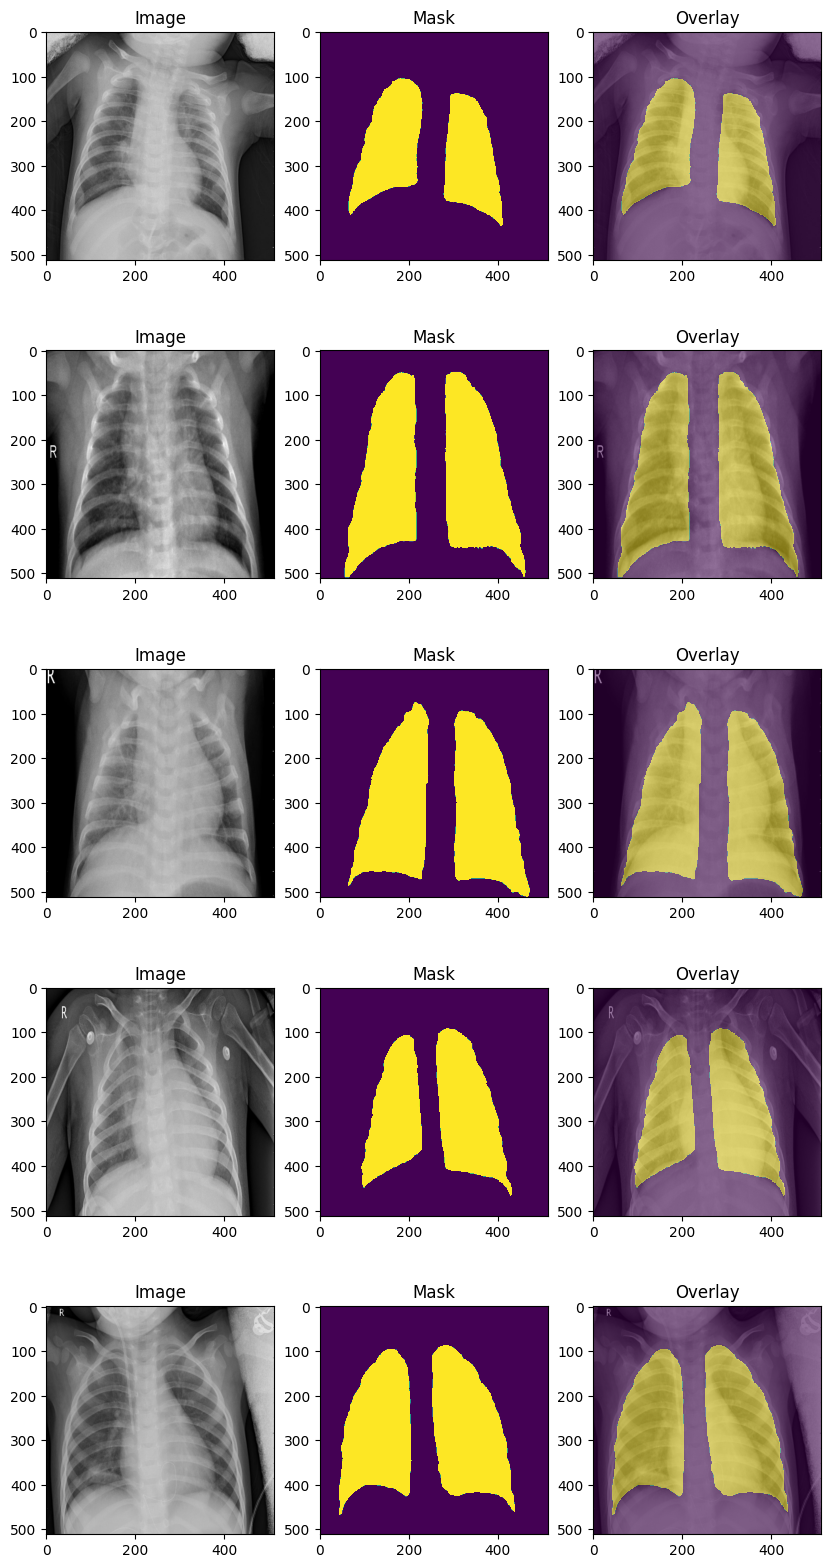

In [10]:
# Visualizing five random images and their masks

fig, axes = plt.subplots(5, 3, figsize=(10, 20))
random_rows = data_df.sample(5).reset_index(drop=True)
for i, row in random_rows.iterrows():
    img = skimage.io.imread(row['image'])
    mask = skimage.io.imread(row['mask'])
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 1].imshow(mask, interpolation='nearest')
    axes[i, 2].imshow(img, cmap='gray')
    axes[i, 2].imshow(mask, interpolation='nearest', alpha=0.5)
    axes[i, 0].set_title('Image')
    axes[i, 1].set_title('Mask')
    axes[i, 2].set_title('Overlay')

**Step 3- Color channels**: Taking a look at the unique values in the segmentation masks, will help us understand the distribution of the classes in our images. In our case, we have only one class to be segmented (lung), so the unique values should be either 0 for background or 1 for object (lung). If the present classes are different, we need to figure out the cause and address that.

We expect to have only one color channel for each pixel and only two possible values for all pixels (0 or 1). If our images are stored in RGB format, each pixel will have 3 values ranging from 0 to 255, one value for red, one for green, and one for blue (RGB). The values range from 0 to 255 to reflect the intensity of each RGB channel. For instance, the yellow of the lungs is actually R=255, G=255, B=0. But we want it to be a single channel with value '1'. And the pixels that aren't lungs, we show as a purple scale so you can see the non-lung part of the image. But at the margin of the lung and non-lung, the display system of the computer may attempt to create values between the bright yellow of lung and purple of non-lung, and that is why we see and different color at the edge. In this case, the intermediate values usually belong to the mask's borders, which contain pixels with intermediate colors. In a grayscale image, each pixel contains a single color channel, but that channel can contain several unique values between 0 and 255. A mask image must have only one channel with two possible values (0 or 1) in each pixel.

To check if our masks are in the appropriate shape, we should convert the image's shape to an image with one color channel and then we should convert all the intermediate values between 0 and 255 to binary values.

In [11]:
mask = skimage.io.imread(data_df['mask'][0])
print(mask.shape)

(512, 512)


Our result contains 2 values (the X and Y dimensions) with no output for the color channel (the third parameter) which means this image has only one color channel.
Now we get all the unique pixel values in our masks, to check if they are binary images.

In [12]:
# Figuring out the unique values in masks

unique_mask_values = set()
print(f'Unique values in the first mask: {np.unique(mask)}')

Unique values in the first mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  25  26  27  28  29  30  31  32  34  35  36  37
  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  56  57
  58  59  60  61  62  64  66  67  68  70  71  72  73  74  75  76  78  79
  81  82  83  84  86  88  89  90  91  92  94  96  97  98  99 100 101 102
 104 105 106 107 108 110 112 113 114 115 116 117 118 119 120 121 122 123
 124 126 128 129 130 131 132 133 135 136 137 138 139 141 142 144 145 147
 149 151 153 154 155 156 157 160 161 162 163 164 165 167 169 171 173 174
 176 177 179 180 181 183 184 185 186 187 188 189 191 192 193 195 196 197
 198 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 223 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255]


Our masks contain a single color channel but several unique values fof that color channel. To replace the intermediate values by only 0 and 1, we use np.where(), which is a numpy function to replace index values if a certain condition is satisfied.

The cell below goes through each pixel value and if a specific condition is satisfied (pixel value is equal to 255) the value is replaced by the second parameter (1). If the condition is not satisfied it is replaced by the third parameter (0).

You might wonder if you should instead say that if the pixel value is greater than 128, it becomes a 1, else a 0. How would you change the code below to accomplish that?
Answer: mask = np.where(mask>=128, 1, 0)

**Side question:** How did we get these intermediate values from a simple single-color mask? The answer is that the pixel values were interpolated when the size of the image was changed. This is the correct way to handle gray scale images like the CXR itself, but not correct for masks. When changing the size of a mask image, we need to specify 'nearest neighbor' as the method of interpolation.



In [ ]:
# Cleaning the mask so that they only include the values 0 and 1

cleaned_masks = []
for i, row in tqdm(data_df[:9].iterrows(), total=9):
    mask = skimage.io.imread(row['mask'])
    mask = np.where(mask==255, 1, 0)
    cleaned_masks.append(mask)

fig, axes = plt.subplots(3, 3, figsize=(10, 11))
for i, mask in enumerate(cleaned_masks):
    axes[i//3, i%3].imshow(mask)
    axes[i//3, i%3].set_title(f'image {i+1}\nunique values: {np.unique(mask)}')
    axes[i//3, i%3].axis('off')

**Step 4- Image size**: Another aspect of the data to look at is the shape (size) of the images and masks. Surprisingly, some datasets (specifically public datasets like ours) may have images of different sizes, particularly if they were acquired on different imaging devices. In that case, the images may need to be resized or cropped to a unified size because deep learning models require that all images be the same size.

In [14]:
# Retreiving all images, masks, and saving the shapes of the images and masks

masks = []
image_shapes = []
mask_shapes = []
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    img = skimage.io.imread(row['image'])
    # images.append(img)
    image_shapes.append(img.shape)
    mask = skimage.io.imread(row['mask'])
    mask = np.where(mask==255, 1, 0)
    masks.append(mask)
    mask_shapes.append(mask.shape)

100%|██████████| 3984/3984 [00:45<00:00, 86.99it/s]


Unique shapes of images: {(512, 512, 3)}
Unique shapes of masks: {(512, 512)}


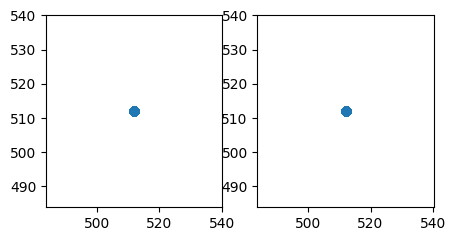

In [15]:
# Plot the distribution of the shapes of the images and masks

fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
for i, shapes in enumerate([image_shapes, mask_shapes]):
    shapes_x = [shape[0] for shape in shapes]
    shapes_y = [shape[1] for shape in shapes]
    axes[i].plot(shapes_x, shapes_y, 'o')
print(f'Unique shapes of images: {set(image_shapes)}')
print(f'Unique shapes of masks: {set(mask_shapes)}')

As you can see our images are the same in shape, so no further action is required.

**Step 5- Other problematic factors**: An experienced data scientist will be aware of other factors that can potentially affect the performance of the model. These factors are specific to each type of imaging and mask.

In our case, a good example is the mask areas, which are representative of lung size. To train a robust model, this parameter should be distributed equally between the training and test datasets. Let's check this in our dataset.
We will learn how to unify the distribution of mask area between the training and test datasets, later in this chapter.

In [16]:
# Adding the mask_area column to the dataframe

mask_areas = [mask.sum() for mask in masks]
data_df['mask_area'] = mask_areas
data_df.head()

,patient,image,mask,mask_area
0,person553,data/Darwin/img/00002470_person553_bacteria_23...,data/Darwin/mask/00002470_person553_bacteria_2...,101278
1,person515,data/Darwin/img/00000762_person515_virus_1032.png,data/Darwin/mask/00000762_person515_virus_1032...,76049
2,person158,data/Darwin/img/00001051_person158_virus_312.png,data/Darwin/mask/00001051_person158_virus_312.png,101777
3,person1057,data/Darwin/img/00004349_person1057_bacteria_2...,data/Darwin/mask/00004349_person1057_bacteria_...,88235
4,person371,data/Darwin/img/00003073_person371_bacteria_16...,data/Darwin/mask/00003073_person371_bacteria_1...,66690


Text(0, 0.5, 'Number of images')

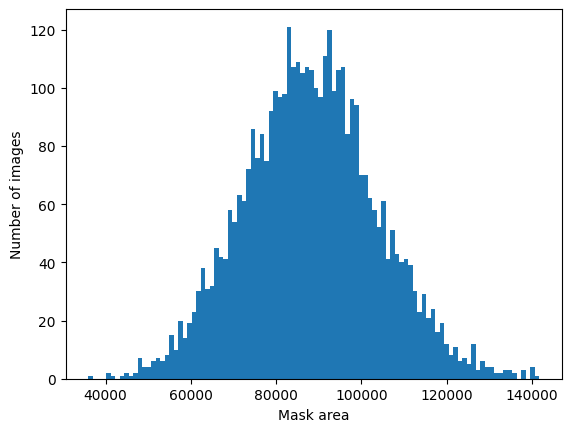

In [17]:
# Plot the distribution of the mask areas

plt.hist(mask_areas, bins=100);
plt.xlabel('Mask area')
plt.ylabel('Number of images')

### **Data Splitting**

Now, it's time to split the data into training and test sets. We will use a 80/20 split, which means that 80% of the data will be used for training, and the remaining 20% will be used for testing. We will use the subject IDs to split the data to ensure that the training and test sets do not have any overlapping patients (that is, a given subject will only be in either the training or testing set). Furthermore, we stratify the split based on the mask areas to ensure that the training and testing sets have similar distributions of the mask areas. To do so, we can use a Scikit-learn class called StratifiedGroupKFold. This function only works with categorical variables. To use it, we categorize the mask areas into 10 bins.

In [18]:
# Now let's bin the mask areas into 10 bins

data_df['mask_area_bin'] = pd.cut(data_df['mask_area'], bins=10).astype(str)
data_df.head()

,patient,image,mask,mask_area,mask_area_bin
0,person553,data/Darwin/img/00002470_person553_bacteria_23...,data/Darwin/mask/00002470_person553_bacteria_2...,101278,"(99357.2, 109928.9]"
1,person515,data/Darwin/img/00000762_person515_virus_1032.png,data/Darwin/mask/00000762_person515_virus_1032...,76049,"(67642.1, 78213.8]"
2,person158,data/Darwin/img/00001051_person158_virus_312.png,data/Darwin/mask/00001051_person158_virus_312.png,101777,"(99357.2, 109928.9]"
3,person1057,data/Darwin/img/00004349_person1057_bacteria_2...,data/Darwin/mask/00004349_person1057_bacteria_...,88235,"(78213.8, 88785.5]"
4,person371,data/Darwin/img/00003073_person371_bacteria_16...,data/Darwin/mask/00003073_person371_bacteria_1...,66690,"(57070.4, 67642.1]"


In [19]:
# Split the data into train and test sets while grouping by patient and stratifying by mask area
# We split the data into five even folds and will use the last fold as the test set.

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(cv.split(data_df, data_df['mask_area_bin'], data_df['patient'])):
    data_df.loc[test_idx, 'fold'] = fold + 1
data_df['set'] = data_df['fold'].apply(lambda x: 'test' if x == 5 else 'train')
data_df.head()

,patient,image,mask,mask_area,mask_area_bin,fold,set
0,person553,data/Darwin/img/00002470_person553_bacteria_23...,data/Darwin/mask/00002470_person553_bacteria_2...,101278,"(99357.2, 109928.9]",3.0,train
1,person515,data/Darwin/img/00000762_person515_virus_1032.png,data/Darwin/mask/00000762_person515_virus_1032...,76049,"(67642.1, 78213.8]",1.0,train
2,person158,data/Darwin/img/00001051_person158_virus_312.png,data/Darwin/mask/00001051_person158_virus_312.png,101777,"(99357.2, 109928.9]",2.0,train
3,person1057,data/Darwin/img/00004349_person1057_bacteria_2...,data/Darwin/mask/00004349_person1057_bacteria_...,88235,"(78213.8, 88785.5]",5.0,test
4,person371,data/Darwin/img/00003073_person371_bacteria_16...,data/Darwin/mask/00003073_person371_bacteria_1...,66690,"(57070.4, 67642.1]",2.0,train


When the data splitting is done, you should compare the grouping and stratification variables in the training and test sets, to ensure that the splitting was done as expected.

In [20]:
# Check if any patient is in both the train and test sets

assert len(set(data_df[data_df['set'] == 'train']['patient']).intersection(
    set(data_df[data_df['set'] == 'test']['patient']))) == 0, \
        'Some patients are in both the train and test sets!'

Note the use of the Python *assert* function.
This is somewhat like the 'if' statement, except that if the test returns false, it goes on to print out the error message, and also raises an AssertionError which can cause the program to stop.

In [ ]:
# Plot the distribution of the mask areas in the train and test sets

sns.displot(data_df, x='mask_area', hue='set', kind='kde', fill=True, common_norm=False, palette='Set2');

### **Data Transformations**

The last step before training a model is to create the transformation pipeline that the data will go through during the training process. The transformation pipeline is a sequence of transformations that will be applied to the data to perform normalization, resizing, data augmentation, etc.

We use the MONAI package which is a PyTorch-based open-source library specialized for deep learning in medical imaging. It provides a very useful set of pre-built transforms, documented [here](https://docs.monai.io/en/latest/transforms.html).

To apply MONAI transforms we create a list of dictionaries to be applied to each data sample, containing the image characteristics. Each dictionary represents 1 type of transformation to be applied to the data. In this way, it is simple to create a list of transformations, and we can create different ones for the train set and the test set.

In [22]:
# Creating a list of record dictionaries for the train and test sets

train_data_list = data_df[data_df['set']=='train'].to_dict('records')
test_data_list = data_df[data_df['set']=='test'].to_dict('records')
print(f'Number of records in the train data list: {len(train_data_list)}')
print(f'Number of records in the test data list: {len(test_data_list)}')

# Let's visualize the first record in the train data list
train_data_list[0]

Number of records in the train data list: 3187
Number of records in the test data list: 797


{'patient': 'person553',
 'image': 'data/Darwin/img/00002470_person553_bacteria_2317.png',
 'mask': 'data/Darwin/mask/00002470_person553_bacteria_2317.png',
 'mask_area': 101278,
 'mask_area_bin': '(99357.2, 109928.9]',
 'fold': 3.0,
 'set': 'train'}

Now we define two separate but similar transformations for the training and validation datasets.

**The transformations often used on training data include:**
Loading the image (dictionary #1 in the cell below), redefining the "mask" color channels as 0 or 1 (#2), rescaling the "image" color channels to be between 0 and 1 (#9), unifying the order of items in the images dimension (#3), transposing and rotating the images back to their original direction (#4), random rotation / flip/ zoom to check if our algorithm works properly in different settings (#5-7), unifying the image sizes (#8) and converting the data back to PyTorch Tensors (#10).

**The transformations applied to the test set** are similar to those applied to the training set despite the random changes the model makes to images to augment the training.



In [23]:
# Defining the transformations for building the train and validation datasets
# We will resize the images and masks to 128x128 pixels, as training on larger images will take a lot of time (especially on Google Colab).

target_size = (128, 128)

train_transforms = mn.transforms.Compose([
    #1:
    mn.transforms.LoadImaged(keys=['image', 'mask']),
    #2:
    mn.transforms.Lambdad(keys=['mask'], func=lambda x: np.where(x==255, 1, 0)),
    #3:
    mn.transforms.EnsureChannelFirstd(keys=['image', 'mask']),
    #4:
    mn.transforms.Transposed(keys=['image', 'mask'], indices=[0, 2, 1]),
    #5:
    mn.transforms.RandRotated(keys=['image', 'mask'], range_x=(-0.5, 0.5), prob=0.5, mode=('bilinear', 'nearest')),
    #6:
    mn.transforms.RandFlipd(keys=['image', 'mask'], spatial_axis=1, prob=0.5),
    #7:
    mn.transforms.RandZoomd(keys=['image', 'mask'], min_zoom=0.9, max_zoom=1.1, prob=0.5, mode=('bilinear', 'nearest')),
    #8:
    mn.transforms.Resized(keys=['image', 'mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
    #9:
    mn.transforms.ScaleIntensityd(keys=['image'], minv=0, maxv=1),
    #10:
    mn.transforms.ToTensord(keys=['image', 'mask'])
])

test_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=['image', 'mask']),
    mn.transforms.Lambdad(keys=['mask'], func=lambda x: np.where(x==255, 1, 0)),
    mn.transforms.EnsureChannelFirstd(keys=['image', 'mask']),
    mn.transforms.Transposed(keys=['image', 'mask'], indices=[0, 2, 1]),
    mn.transforms.Resized(keys=['image', 'mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
    mn.transforms.ScaleIntensityd(keys=['image'], minv=0, maxv=1),
    mn.transforms.ToTensord(keys=['image', 'mask'])
])

Now we are going to cache the transformed data so that we can use it without the need for redoing the transformation at each subsequent step. However, the random transformations will be conducted again for each step, since that is important to have keep changing.
Caching the results will substantially reduce the processing time.

In [24]:
# First, we must delete any previous cached data
shutil.rmtree('cache', ignore_errors=True)

# Then, we will build the train and test datasets and dataloaders
train_ds = mn.data.dataset.PersistentDataset(data=train_data_list, transform=train_transforms, cache_dir='cache/train')
train_dl = mn.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)

test_ds = mn.data.dataset.PersistentDataset(data=test_data_list, transform=test_transforms, cache_dir='cache/test')
test_dl = mn.data.DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4)

# Let us visualize few samples from train set

In [ ]:
# Display a dummy batch from the train dataloader

dummy_batch = next(iter(train_dl))
fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i in range(8):
    axes[i, 0].imshow(dummy_batch['image'][i, 0], cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(dummy_batch['mask'][i, 0],interpolation='nearest')
    axes[i, 1].set_title('Mask')
    axes[i, 2].imshow(dummy_batch['image'][i, 0], cmap='gray')
    axes[i, 2].imshow(dummy_batch['mask'][i, 0], interpolation='nearest', alpha=0.5)
    axes[i, 2].set_title('Overlay')

As you can see, we have caused rotations and flips in random images and their corresponding masks.

## **Model, Loss, and Metric**

After handling the data, it's time to define the model, the loss, and the metrics we will use for the training. In this chapter, we will use a U-Net model for segmentation. The U-Net model is a convolutional neural network (CNN) that is designed for image segmentation. You can find the original paper for the U-Net model [here](https://arxiv.org/abs/1505.04597). The U-Net model is a fully convolutional network, which means that it does not have any fully connected layers. This makes it easy to use for segmentation tasks, as the output of the model can be of any size.

The U-Net model is composed of an encoder and a decoder. The encoder is a sequence of convolutional layers that are used to extract features from the input image. The decoder is a sequence of convolutional layers that are used to upsample the features extracted by the encoder, generating the output. The decoder is also used to concatenate the features extracted by the encoder with the upsampled features. This helps the decoder to learn the context of the features. You can read more about how to implement each kind of UNETs in the [MONAI docs](https://docs.monai.io/en/stable/networks.html) . The U-Net model is shown below:

<center>
<img src="https://i.ibb.co/q5hdfzT/2.png" alt="2" border="0" height="400">
</center>

Although the vanilla U-Net model was a great breakthrough in the field of image segmentation, the more recent variants are even more powerful.
One way to improve a vanilla U-Net model is to replace its original encoder with an existing architecture that has been used for image classification.
For example, the EfficientNet-B0 encoder is a CNN designed to improve the efficiency of UNETs. You can find the original paper for EfficientNet [here](https://arxiv.org/abs/1905.11946).

To design a FlexibleUNet class, we need to define these input arguments:

in_channels: The number of input channels depends on the characteristics of your images. In our case, the shape of our images is (512, 512, 3), which means our image is in RGB color model with three primary color channels of red, green and blue (though the values for each channel for a given pixel are the same, resulting in some black-gray-white color). So the input channels should be 3.

out_channels: The number of output channels depends on the number of classes you want to segment. In our case we put 2 for lungs and the background. If you wanted to segment the lungs and the heart (plus background), for instance, the output channels would be 3.

backbone: The network we are going to use for feature extraction, like EfficientNet which is a CNN.

pretrained: If you are using a particular value for the weights in your model which were learned based on previous training of the same model on another dataset, you are using 'pretrained' weights. Without these pretrained weights, the model will set the weights to random values, and it must learn from scratch, typically reuiring much more data and a longer training time.

Remember to transfer your model to the GPU (CUDA for NVIDIA GPUs) before applying it.

In [26]:
# Defining a UNet model from MONAI

model = mn.networks.nets.FlexibleUNet(
    in_channels=3,
    out_channels=2,
    backbone='efficientnet-b0',
    pretrained=True,
)

model = model.to('cuda')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 18.3MB/s]


Although we loaded the U-Net model from MONAI with just 1 line of code, we should remember that our model is a complicated object consisting of many layers and parameters behind the scenes. We can print the model to see its different layers:

In [27]:
# Print the model

print(model)

FlexibleUNet(
  (encoder): EfficientNetBNFeatures(
    (_conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (_blocks): Sequential(
      (0): Sequential(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_expand_conv_padding): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
          (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (_se_reduce_padding): Identity()
          (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), 

Before training our entire dataset, let's test our model on a single batch from our training set to ensure everything is working as expected.

Remember to transfer your batch to the GPU (the model was already transferred to the GPU).

By applying the model to the batch of images, the output logit will be a tensor of each pixel's "probability of being a part of our mask or not". The size of this tensor will be the same as the size of our images. Let's see:


In [28]:
# Testing the model on the dummy batch
# Please note the performance of the model will be very poor on the dummy batch as we have not trained it yet.

dummy_img = dummy_batch['image'].to('cuda')
dummy_mask = dummy_batch['mask'].to('cuda')
dummy_logits = model(dummy_img)

print(dummy_logits.shape)


(8, 2, 128, 128)


The shape of logits are: (8, 2, 128, 128)

The first number is the number of images in the batch;the second value is the color channels which are set to be 2 as our segmentation is classifying the image into two parts: the target and the background.
The third and fourth values are the output image size. Remember that we resized our images to 128 * 128 during the preprocessing.

Now let's visualize the results:

We use the argmax to visualize our results on the corresponding images. Our model predicts two probabilities for each pixel: the pixel's probability to be of color channel 'zero' and its probability to be of channel 'one'. Argmax picks the higher probability between these two and only keeps this value. If the probability of a pixel to be in a target area (channel = 1) is higher than not a target (background or 0) the area will be presented as a target. If the probability is higher for channel 0, this pixel will be presented as background. If the two values are the same, the pixel will be considered a background as is defined for Argmax.

# Performance without training

In [ ]:
# lets see what the segmentation looks like before training it

fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i, (img, mask, logit) in enumerate(zip(dummy_img, dummy_mask, dummy_logits)):
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(mask[0].detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 1].set_title('Ground truth segmentation')
    axes[i, 2].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 2].imshow(logit.argmax(dim=0).detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 2].set_title('Predicted segmentation')

The performance of this pre-trained model is poor (it would be worse if we didn't use a pre-trained model), but remember the model was not trained to find lungs on CXRs!

The raises the question of how we should measure the performance of the model. Deep learning models use a 'loss function' to update weights, so the loss function for segmentation needs to reflect how good the model is doing at segmenting. To evaluate the performance of our model we should measure its loss function, which is the difference between the predicted and the ground truth segmentation masks. The resulting values will be used to update the model parameters during training.

Although there are different metrics for reporting the performance of a segmentation model (including Dice coefficient, Jaccard index, Hausdorff distance, Intersection over Union, etc.), the Dice coefficient is the most common one, and that compares the truth mask and the prediction mask, both of which are 1's and 0's.

While the Dice is a good measure, it is better to use it in combination with another measure like the Cross-entropy loss, which you likely remember from classification.

1- **The Dice loss**: The Dice loss is a loss function that measures the overlap between the predicted segmentation mask and the ground truth segmentation mask. It will penalize the model if the overlap is low. The Dice loss is defined as:

<center><img src="https://i.ibb.co/cxXs5z8/3.png" alt="3" border="0"></center>

The higher Dice coefficients produce lower loss values. For an optimal model with 100% overlap, this value will be equal to 1 and for the worst models with no overlap between the masks, the Dice coefficient will be equal to 0. Of course, if there is no overlap, the value is 1, and there may be no gradient to help it find the way to some overlap, and so we often add another component.

2- **The Cross-entropy loss** that is used for classfication tasks (imagine a segmentation task as a classification task at the pixel level). This helps to provide a gradient in places where there is little overlap or the overlap isn't changing (e.g. the prediction is that every pixel is object).

The final loss we use will be a simple average of the two losses.

MONAI has a class to combine these two methods of estimating the loss:  the DiceCELoss (CE = Cross Entropy)

In [30]:
# Define the loss function and test it on the dummy batch

loss_fn = mn.losses.DiceCELoss(include_background=True, to_onehot_y=True, sigmoid=False, softmax=True)
loss = loss_fn(dummy_logits, dummy_mask)

# Question: Why did not we do the following instead of the above?

loss.item()

1.282641887664795

While we understand that each pixel can be a '1' or  '0', it can be useful (particularly for multiclass problems) to have a binary mask for each class. While you could write code to do this, it is such a common function, that it is built into PyTorch, and there is even a special name: One Hot Encoding.

to_onehot_y: In onehot format, each pixel has a binary value for each class of interest. In our case, each pixel is either 0 or 1 for being a background channel **and** is either 0 or 1 for being a mask channel. This is presented as a list of binary values (e.g.,[0,1]). The length of this list is equal to the number of classes we want to segmentate.
If we have converted our masks to this format in preprocessing, we can put this parameter as False, but if we have not performed this we should insert True. Sample code to separately transform our masks to onehot format would be:
>> onehot_dummy_mask = mn.networks.utils.one_hot(dummy_mask, num_classes=2)

Since we use the argmax function to pick the right class, we need to first be sure that the range of values going into it are ranged properly. We can apply softmax method by inserting softmax=True in the Dice model or by separately applying it later:
>> dummy_pred = torch.softmax(dummy_logits, dim=1)\
>>loss = loss_fn(dummy_pred, dummy_mask)

We could also use the Dice coefficient alone to evaluate our model's performance. Instead, we are going to use a MONAI function in the following lines that is designed to give Dice coefficient metrics for segmentation models. We should perform the onehot and softmax transformations separately, as the DiceMetric function is not designed to perform it for us.
Let's try it:

In [31]:
# Define the evaluation metric.
# Note that the DiceMetric class expects one-hot encoded inputs and unlike DiceCELoss, it does not perform softmax on the input.

dice_metric_fn = mn.metrics.DiceMetric(include_background=True)

onehot_dummy_mask = mn.networks.utils.one_hot(dummy_mask, num_classes=2)

dummy_pred = torch.softmax(dummy_logits, dim=1)
dummy_pred = torch.argmax(dummy_pred, dim=1, keepdim=True).float()
onehot_dummy_pred = mn.networks.utils.one_hot(dummy_pred, num_classes=2)

dice = dice_metric_fn(y_pred=onehot_dummy_pred, y=onehot_dummy_mask)
dice.tolist()

[[0.43785038590431213, 0.34297439455986023],
 [0.4096277952194214, 0.4593978226184845],
 [0.3772348463535309, 0.2953229546546936],
 [0.45543667674064636, 0.3483273983001709],
 [0.3850003480911255, 0.48163771629333496],
 [0.4367785155773163, 0.5353383421897888],
 [0.388266921043396, 0.4170689582824707],
 [0.35305026173591614, 0.4472865164279938]]

As you see, the output is a 8*2 tensor of metrics. The first number is the number of images in each batch and the second is the number of segmented classes. The Dice metric gives separate loss values for each segmented class (Background or Mask).

**Question: How did the first method reach a single value?**

The DiceCELoss calculates an overall estimate of all the values in each batch (16 values in our case) by a particular formula. We can modify the weights of each class in this formula to change the impact of each class on the final loss. This will come handy when the segmented object(s) is relatively small compared to background (e.g., vertebral bodies versus the rest of the image).   

## **Training**

Finally, it's time to train the model. Training a segmentation model is no different than training a classification model. We need a training loop to iterate over the training data and update the model parameters, and a validation loop to evaluate the model performance on some data that the model does not see during training. The latter will also be used to select the best model (the model with the lowest validation loss) and to save its weights.

We will start by defining some training hyperparameters...


In [32]:
# Training hyperparameters

# Our segmentation task is not very complex, so we will train the model for only 5 epochs.
num_epochs = 5

# We will use the AdamW optimizer with a learning rate of 1e-4
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Feel free to change the batch size and number of workers depending on your system's configuration (available GPU power)
batch_size = 16
train_dl = mn.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = mn.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

The training and validation loops are shown below. Please note how we log the loss and metric values at the end of each batch, and then collect the average loss and metric values at the end of each epoch.
The loss and metric values for each epoch are stored in a list to be visualized later.
Remember to put model.train() before the training loop and model.eval() before the validation loop. This turns on the updating of weights ('.train') or turns it off('.eval').
**What would happen if we left the weight updating always on? **

We also calculate the logits under the no_grad function to tell the loop that you are not looking for any gradient descent and optimization in the validation loop.

We also save the model any time the validation loss is better than the previously saved best model.

In [ ]:
# Training and validation loops

training_loss = []
validation_loss = []

training_dice_metrics = []
validation_dice_metrics = []

best_validation_loss = None

for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')

    # Training loop

    epoch_training_loss = []
    epoch_training_dice_metrics = []

    model.train()
    for batch in tqdm(train_dl, desc='Training'):
        img = batch['image'].to('cuda')
        mask = batch['mask'].to('cuda')

        optimizer.zero_grad()

        logits = model(img)
        loss = loss_fn(logits, mask)
        loss.backward()
        optimizer.step()
        epoch_training_loss.append(loss.item())

        pred = torch.softmax(logits, dim=1)
        pred = torch.argmax(pred, dim=1, keepdim=True).float()
        onehot_pred = mn.networks.utils.one_hot(pred, num_classes=2)
        onehot_mask = mn.networks.utils.one_hot(mask, num_classes=2)
        dice = dice_metric_fn(y_pred=onehot_pred, y=onehot_mask)
        dice = torch.mean(dice)
        epoch_training_dice_metrics.append(dice.item())

    # Validation loop

    epoch_validation_loss = []
    epoch_validation_dice_metrics = []

    model.eval()
    for batch in tqdm(test_dl, desc='Validation'):
        img = batch['image'].to('cuda')
        mask = batch['mask'].to('cuda')

        with torch.no_grad():
            logits = model(img)
            loss = loss_fn(logits, mask)
            epoch_validation_loss.append(loss.item())

        pred = torch.softmax(logits, dim=1)
        pred = torch.argmax(pred, dim=1, keepdim=True).float()
        onehot_pred = mn.networks.utils.one_hot(pred, num_classes=2)
        onehot_mask = mn.networks.utils.one_hot(mask, num_classes=2)
        dice = dice_metric_fn(y_pred=onehot_pred, y=onehot_mask)
        dice = torch.mean(dice)
        epoch_validation_dice_metrics.append(dice.item())

    # Logging the epoch metrics
    epoch_training_loss = torch.mean(torch.tensor(epoch_training_loss))
    epoch_validation_loss = torch.mean(torch.tensor(epoch_validation_loss))
    epoch_training_dice = torch.mean(torch.tensor(epoch_training_dice_metrics))
    epoch_validation_dice = torch.mean(torch.tensor(epoch_validation_dice_metrics))
    training_loss.append(epoch_training_loss.item())
    validation_loss.append(epoch_validation_loss.item())
    training_dice_metrics.append(epoch_training_dice.item())
    validation_dice_metrics.append(epoch_validation_dice.item())

    # Saving the model
    if best_validation_loss is None or epoch_validation_loss < best_validation_loss:
        best_validation_loss = epoch_validation_loss
        os.makedirs('weights', exist_ok=True)
        torch.save(model.state_dict(), 'weights/best_model.pth')
        print('Saved best model!')

    print("*"*50)


## **Evaluation**

After training the model, it's time to visualize how the loss and metric values changed during training. We will use matplotlib to visualize the loss and metric values for both training and validation sets.

**Question: How do you explain the different trends of loss values for the training and validation sets?**

In [ ]:
# Plotting the training and validation loss and dice metrics

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(training_loss, label='Training loss')
axes[0].plot(validation_loss, label='Validation loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(training_dice_metrics, label='Training dice')
axes[1].plot(validation_dice_metrics, label='Validation dice')
axes[1].set_title('Dice')
axes[1].legend()

In this case our model is working better in the validation than the training which means our problem was relatively easy to solve for our model, which is not a bad thing.

**Question**:

Why is the validation better?  Remember the values here are the average during the 'current' epoch. The validation results are the average AFTER the weights are updated, so the difference probably reflects that training during the first few epochs is working well, and thus the average validation results are better than the average of the training samples for that epoch.

A standard practice is to save the weights of the best model (defined as having hte lowest loss on the validation set). We will follow that and write out the model weights when the validation loss is less than any previous validation loss.

To use a trained model for inference, we need to load the model weights and set the model to evaluation mode. We will use the best saved model (the model with the lowest validation loss) for inference. Now that we have trained the model ourselves and we have reached the optimal weights, we set the pretrained to be False. The other parameters are set similar to our training experience.

In [ ]:
# Load the trained model
# we start by creating the model which is a place to store the trained model that we will load

model = mn.networks.nets.FlexibleUNet(
    in_channels=3,
    out_channels=2,
    backbone='efficientnet-b0',
    pretrained=False,
)
model.load_state_dict(torch.load('weights/best_model.pth'))
model = model.to('cuda')
model.eval();

Let's visualize the predicted segmentation mask for a sample from the test set. Please compare the model performance before and after the training!

In [ ]:
# Predict a dummy batch from the validation set with the trained model

test_dl = mn.data.DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)
dummy_batch = next(iter(test_dl))
dummy_img = dummy_batch['image'].to('cuda')
dummy_mask = dummy_batch['mask'].to('cuda')
dummy_preds = torch.softmax(model(dummy_img), 1)

fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i, (img, mask, pred) in enumerate(zip(dummy_img, dummy_mask, dummy_preds)):
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(mask[0].detach().cpu(), interpolation='nearest', alpha=0.5)
    axes[i, 1].set_title('Ground truth segmentation')
    axes[i, 2].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 2].imshow(pred.argmax(dim=0).detach().cpu(), interpolation='nearest', alpha=0.5)
    axes[i, 2].set_title('Predicted segmentation')

The model is doing a good job but there are still some descrepancies. For instance, the model doesn't seem to be learning to segment the costovertebral and costocardiac angles in some cases, which may be due to variations of the ground truth segmentation created by different experts.

Segmentation models have a lot of use cases. One of the most common use cases is to crop the image to the region of interest (ROI). In the following cell, we will crop the chest radiographs to include only lung paranchyma.

**Question**: What are some reasons why we might want to crop chest radiographs like that?

In [ ]:
fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i, (img, mask, pred) in enumerate(zip(dummy_img, dummy_mask, dummy_preds)):
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(pred.argmax(dim=0).detach().cpu(), interpolation='nearest', alpha=0.5)
    axes[i, 1].set_title('Predicted segmentation')

    # Using the predicted segmentation to crop the image
    cropped_img = torch.where(pred.argmax(dim=0) == 1, img[0], torch.zeros_like(img[0]))

    axes[i, 2].imshow(cropped_img.detach().cpu(), cmap='gray')
    axes[i, 2].set_title('Cropped image')


You can see now that with very little training time, we have developed a model that will segment the lung fields on chest radiographs with very good performance.

Thank you for reading and hopefully running this notebook. We hope you enjoyed it!

Please feel free to share your thoughts and questions with us...